In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load scientific and plotting libraries 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math

# Load widgets and animation libs 
#from ipywidgets import interact, widgets
#from PIL import Image

# Import random number generators: 
from numpy.random import random
from numpy.random import randn
from numpy.random import randint
from numpy.random import uniform
from numpy.random import choice 
from numpy.random import normal

# Some tools to optimize sim time (work in progress)
import time
#from itertools import product
from numba import jit            # conda install jit

### Specify parameters of simulation, number of particles, box size,  temperature, curoff distance, thermostat parameters

In [6]:
#-----------------------> LJ parameters in reduced units of sigma and epislon
N = 216 
density=0.5                 # density of Argon LJ spheres 0.5-0.88
L =  (N/density)**(1.0/3.0)

dt = 0.001       # dt : time step
rc2 = 3          # rc2 : squared cutoff distance
nSteps = 20000   # nSteps : number of steps of simulation

T = 1.0          # T : temperature
tau = 0.1        # damping const for Berendsen thermostat
Tdamp = 1        # damping const for standard  thermostat

#------------------> Everything fixed byeond this point

### Vectorize data and store postions, velocities and forces on numpy arrays

In [7]:
pos = np.zeros((3,N))
vel = np.zeros((3,N))
force = np.zeros((3,N))

### Initialize positions and velocities

In [8]:
def initialize_pos_vel(N, L, pos, vel):
    
    """put N particles in a box, using dense packing unit lattice size n3"""
    
    n3 = int(N ** (1 / 3.)) + 1
    iix = iiy = iiz = 0
    
    for i in range(N):
        pos[0][i] = (iix + 0.5) * L / n3
        pos[1][i] = (iiy + 0.5) * L / n3
        pos[2][i] = (iiz + 0.5) * L / n3
        iix += 1
        if iix == n3:
            iix = 0
            iiy += 1
            if iiy == n3:
                iiy = 0
                iiz += 1   
                
    """ Create Maxwell Boltzman distribution of velcities"""
    vel[:,:] =  randn(3,N)

def viz_p(pos,L):
    '''Some cheap visualization to see where the particles are located''' 
    
    from mpl_toolkits.mplot3d import axes3d
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d') 
    
    ax.scatter(pos[0,:], pos[1,:], pos[2,:], s = 200) 
    
    ax.set_xlim3d(0,L)
    ax.set_ylim3d(0,L)
    ax.set_zlim3d(0,L)
    ax.set_xlabel("$X\, [\sigma]$",fontsize=18)
    ax.set_ylabel("$Y\, [\sigma]$",fontsize=18)
    ax.set_zlabel("$Z\, [\sigma]$",fontsize=18)
    ax.set_title("MD snapshot",fontsize=20)

### Visualize lattice and velocities

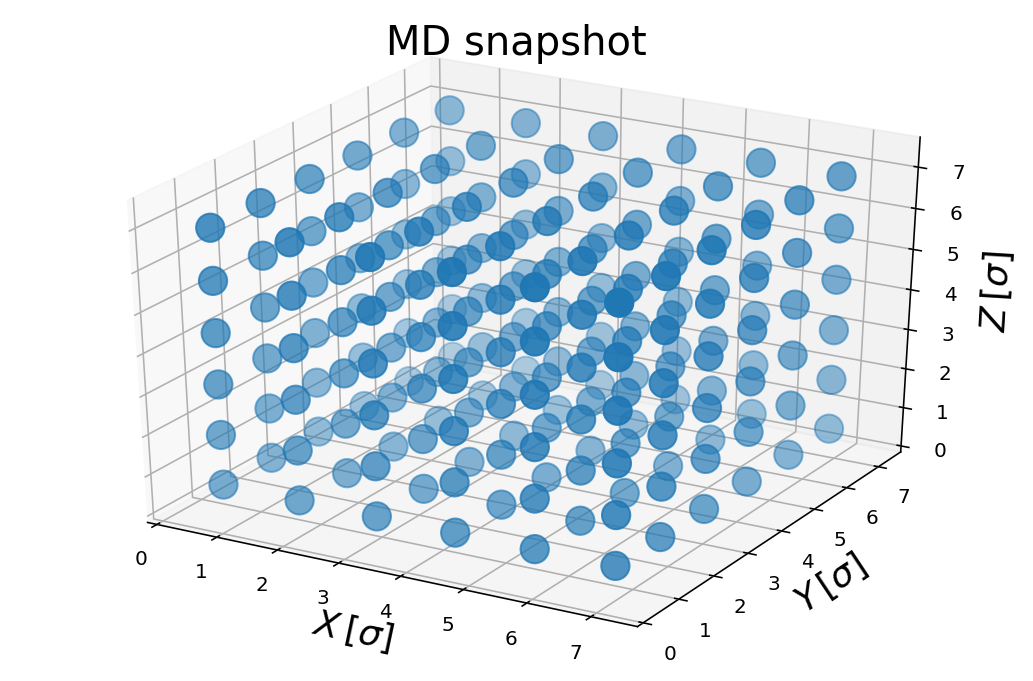

In [9]:
initialize_pos_vel(N, L, pos,vel)
viz_p(pos,L)

In [10]:
# As in MC-LJ; positions, velocities are 3D numpy arrays of shape (d,N) where d is dimensionality
pos.shape,vel.shape

((3, 216), (3, 216))

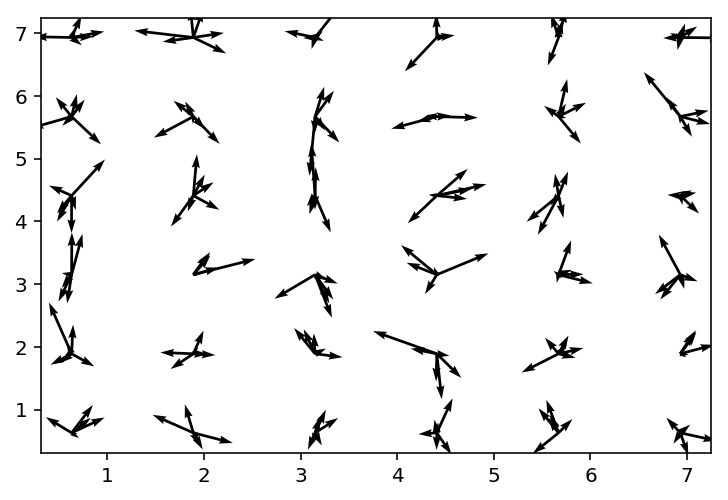

In [11]:
# 2D projection of velocities
plt.quiver(pos[0,:],pos[1,:],vel[0,:],vel[1,:])

(-1, 8)

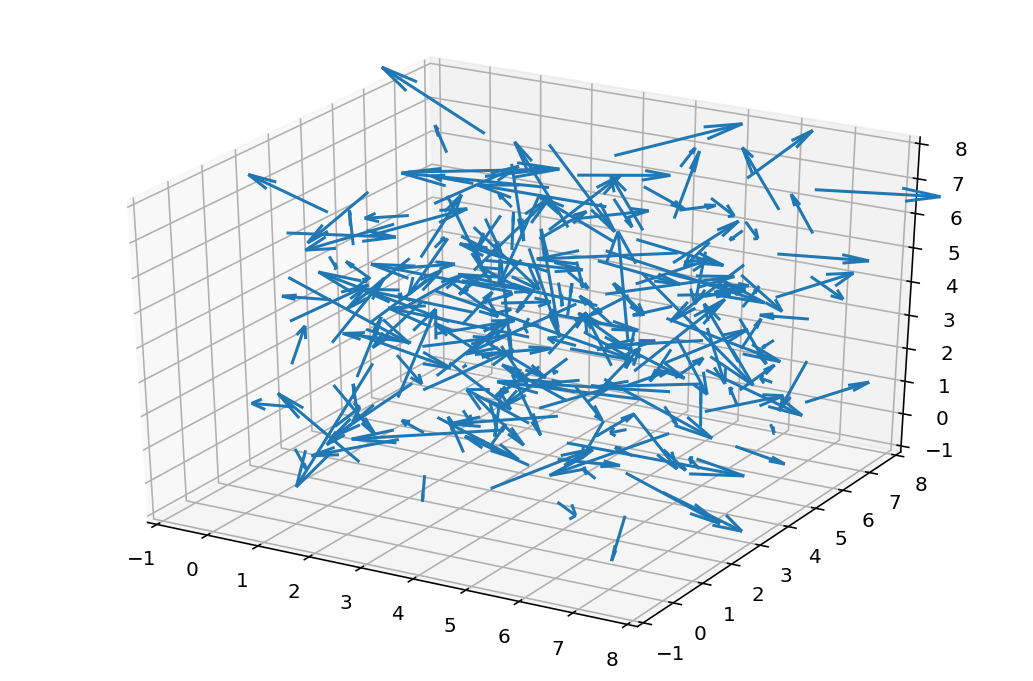

In [12]:
# 3D quiver plot of velocities
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.quiver(pos[0,:],pos[1,:],pos[2,:],vel[0,:],vel[1,:],vel[2,:])
ax.set_xlim([-1,8])
ax.set_ylim([-1,8])
ax.set_zlim([-1,8])

(array([ 1.,  1.,  0.,  0.,  0.,  1.,  0.,  4.,  4.,  1.,  6.,  1.,  3.,
        12.,  2.,  7., 11., 12.,  8., 12., 16., 13., 14., 20., 12., 13.,
         5.,  8.,  8.,  6.,  5.,  4.,  1.,  2.,  0.,  0.,  2.,  0.,  0.,
         1.]),
 array([-3.41825032, -3.24956385, -3.08087739, -2.91219092, -2.74350446,
        -2.57481799, -2.40613153, -2.23744506, -2.06875859, -1.90007213,
        -1.73138566, -1.5626992 , -1.39401273, -1.22532627, -1.0566398 ,
        -0.88795334, -0.71926687, -0.55058041, -0.38189394, -0.21320747,
        -0.04452101,  0.12416546,  0.29285192,  0.46153839,  0.63022485,
         0.79891132,  0.96759778,  1.13628425,  1.30497071,  1.47365718,
         1.64234365,  1.81103011,  1.97971658,  2.14840304,  2.31708951,
         2.48577597,  2.65446244,  2.8231489 ,  2.99183537,  3.16052184,
         3.3292083 ]),
 <a list of 40 Patch objects>)

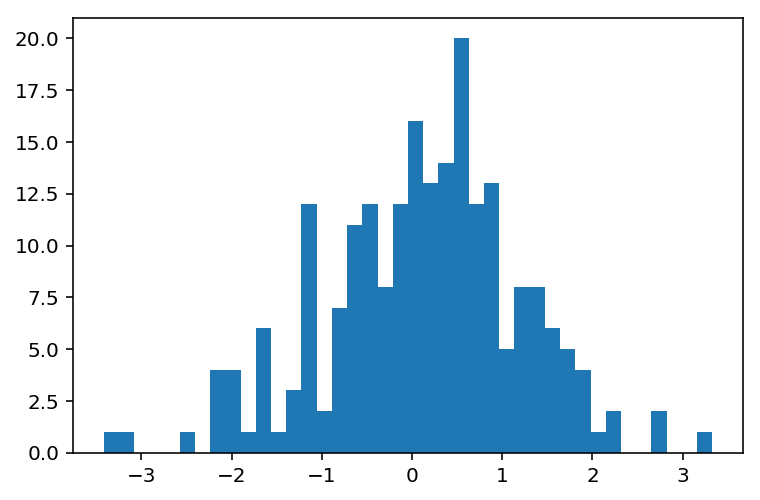

In [13]:
# Velocity distirbution
#V=(vel[0,:]**2+vel[1,:]**2+vel[2,:]**2)**0.5
plt.hist(vel[0,:],40)

### Write main helper function of Molecular dynamics

 1. Initalize pos & velocity, compute initial forces. 
 
 2. Evolve velocities (via a Verlet Algorithm)
 
 3. Enforce PBC
 
 4. Evaluate kinetic and Potential Energies

In [15]:
@jit
def velocity_verlet(dt, pos, vel, i):
    """verloctiy verlet algorithm"""
    
    dt2 = dt * dt
    
    pos[0][i] += vel[0][i] * dt + 0.5 * dt2 * force[0][i]
    pos[1][i] += vel[1][i] * dt + 0.5 * dt2 * force[1][i]
    pos[2][i] += vel[2][i] * dt + 0.5 * dt2 * force[2][i]

    vel[0][i] += 0.5 * dt * force[0][i]
    vel[1][i] += 0.5 * dt * force[1][i]
    vel[2][i] += 0.5 * dt * force[2][i]
    
@jit   
def set_pbc(L, pos, i):
    """Enforce Periodic Boundary conditions"""
    
    #Along X
    if pos[0][i] < 0.0:
        pos[0][i] += L
    if pos[0][i] > L:
        pos[0][i] -= L
    #Along Y    
    if pos[1][i] < 0.0:
        pos[1][i] += L
    if pos[1][i] > L:
        pos[1][i] -= L
    #Along Z   
    if pos[2][i] < 0.0:
        pos[2][i] += L
    if pos[2][i] > L:
        pos[2][i] -= L

        
@jit
def potential_energy(N, L, rc2, pos,force):
    """calculate the potential energy"""
    force.fill(0)
    pot_E = 0.0
    
    # First enforce PBC
    halfL = L / 2.0
    
    for i in range(N-1):
        for j in range(i+1, N):
            
            dx = pos[0][i] - pos[0][j]
            dy = pos[1][i] - pos[1][j]
            dz = pos[2][i] - pos[2][j]

            if dx >halfL:                  
                dx -= L
            if dx < -halfL:
                dx += L
            if dy > halfL:
                dy -= L
            if dy < -halfL:
                dy += L
            if dz > halfL:
                dz -= L
            if dz < -halfL:
                dz += L

            r2 = dx * dx + dy * dy + dz * dz
            
            # Evaluate cutoff
            if r2 < rc2:        
                
                r6i = 1.0 / (r2 * r2 * r2)
                pot_E += 4 * (r6i * r6i - r6i)
                f = 48 * (r6i * r6i - 0.5 * r6i)
                
                force[0][i] += dx * f / r2   # remember the chain rule of differentiation? :) 
                force[0][j] -= dx * f / r2
                force[1][i] += dy * f / r2
                force[1][j] -= dy * f / r2
                force[2][i] += dz * f / r2
                force[2][j] -= dz * f / r2
                
    return pot_E


@jit
def kinetic_energy(N, dt, vel, force):
    """calculate the kinetic energy"""
    
    kin_E = 0.0
    
    for i in range(N):
        
        vel[0][i] += 0.5 * dt * force[0][i]
        vel[1][i] += 0.5 * dt * force[1][i]
        vel[2][i] += 0.5 * dt * force[2][i]
        
        kin_E += vel[0][i] * vel[0][i] + vel[1][i] * vel[1][i] + vel[2][i] * vel[2][i]
        
    kin_E *= 0.5
    
    return kin_E

@jit
def thermostat(kin_E, T, N, vel):
    """simple thermostat via velocity scaling algorithm"""
    
    t = 3.0*kin_E / 2.0 * N
    fac = np.sqrt(T/t)
    
    for i in range(N):
        
        vel[0][i] *= fac
        vel[1][i] *= fac
        vel[2][i] *= fac
@jit
def berendsen_thermostat(N, dt, kin_E, vel):
    """Berendsen thermostat algorithm"""
    
    lamb = np.sqrt(1 + dt / tau * (T / (2.0 * kin_E / 3.0 / N) - 1.0))
    
    for i in range(N):
        
        vel[0][i] *= lamb
        vel[1][i] *= lamb
        vel[2][i] *= lamb

### You can write functions for outputing thermodynamic data, trajecotries and energies for analyzing at a later time

In [14]:
def comp_g_r(pos,N,L):
    '''Computing radial distirbution function for a single configuration'''

    # Number of particles and density
    rho=N/(L**3)

    # Prepare bins for histogramming
    nbins=60
    Lmin=0.0
    Lmax=L/2  
    dr=(Lmax-Lmin)/nbins
    
    #------ Compute distances
    r_distances=[]
    
    halfL = L / 2.0
    
    for i in range(N-1):
        for j in range(i+1, N):
            
            dx = pos[0][i] - pos[0][j]
            dy = pos[1][i] - pos[1][j]
            dz = pos[2][i] - pos[2][j]

            if dx >halfL:                  
                dx -= L
            if dx < -halfL:
                dx += L
            if dy > halfL:
                dy -= L
            if dy < -halfL:
                dy += L
            if dz > halfL:
                dz -= L
            if dz < -halfL:
                dz += L

            r2 = dx * dx + dy * dy + dz * dz
            r_distances.append(math.sqrt(r2))
            
    r_distances=np.array(r_distances)
    #------ 
            
    #Histogram distances 
    histRadii, edges = np.histogram(r_distances,bins=nbins,range=(Lmin,Lmax))
    radii = 0.5 *(edges[1:] + edges[:-1])  # radii of histograms R1,R2,..Lmax 
    
    # often folks loop over N*N pairs then divide by N
    # we have N*N-1/2 pairs e.g must divide by (N-1)/2 to have hist for N particles
    histRadii = histRadii/(0.5*(N-1))    
    
    #Compute histogram that would be displayed by an ideal gas of N particles 
    vol = (4.0/3.0) * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    histIdeal=rho*vol 
    
    gr = histRadii/histIdeal 
    
    return radii,gr

### Main MD engine

In [16]:
def mdrun(N, L, rc2, dt, nSteps, T, pos,vel,force):
    """main MD function"""
    
    dataPE,dataKE,dataTE=[],[],[]
    GR=0
    
    for s in range(nSteps):
        for i in range(N):
            
            velocity_verlet(dt, pos,vel,i)
            set_pbc(L, pos, i)

        PE = potential_energy(N, L, rc2, pos, force)
        KE = kinetic_energy(N, dt, vel, force)
        TE = PE + KE
        
        berendsen_thermostat(N, dt, KE, vel)
        
        
        #---------> Add observables of interest here
        
        dataPE.append(PE)
        dataKE.append(KE)
        dataTE.append(TE)
        
    return np.array(dataPE),np.array(dataKE),np.array(dataTE)

In [17]:
%time 
initialize_pos_vel(N, L,pos,vel)
data=mdrun(N, L, rc2, dt, nSteps, T, pos, vel, force)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


### Visualize output

Text(0.5, 0, 'time steps')

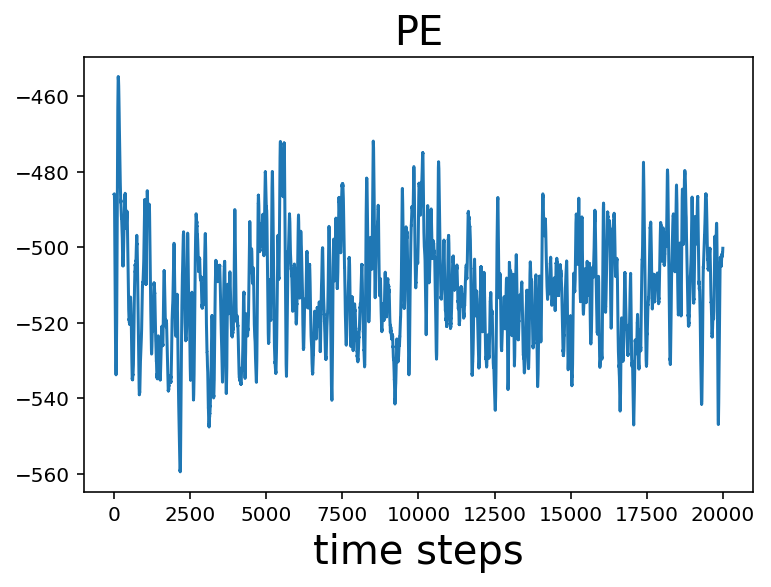

In [18]:
plt.plot(data[0])
plt.title('PE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

Text(0.5, 0, 'time steps')

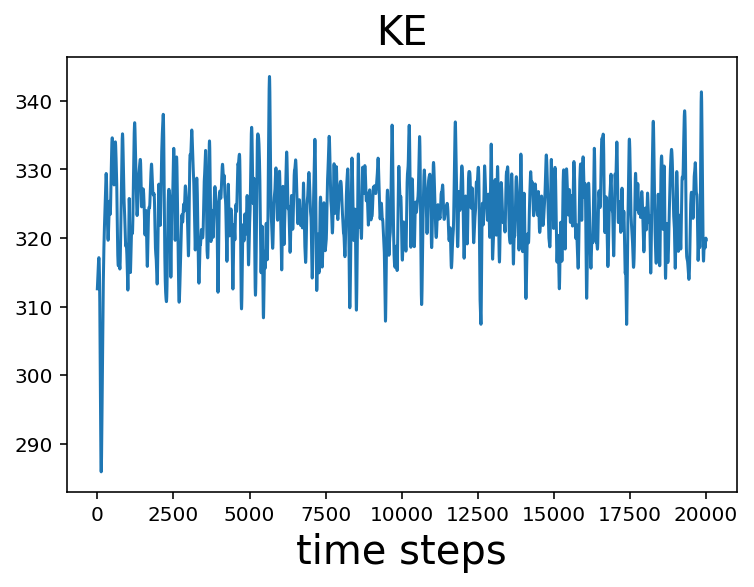

In [19]:
plt.plot(data[1])
plt.title('KE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

Text(0.5, 0, 'time steps')

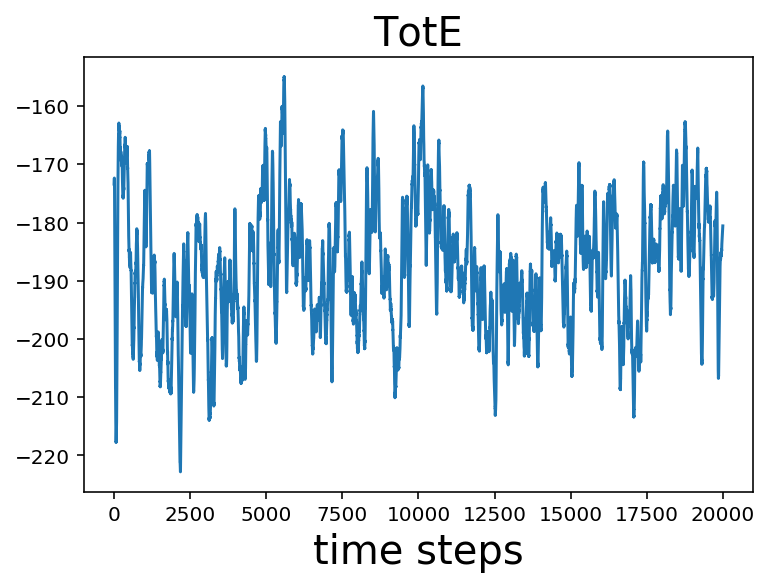

In [20]:
plt.plot(data[2])
plt.title('TotE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

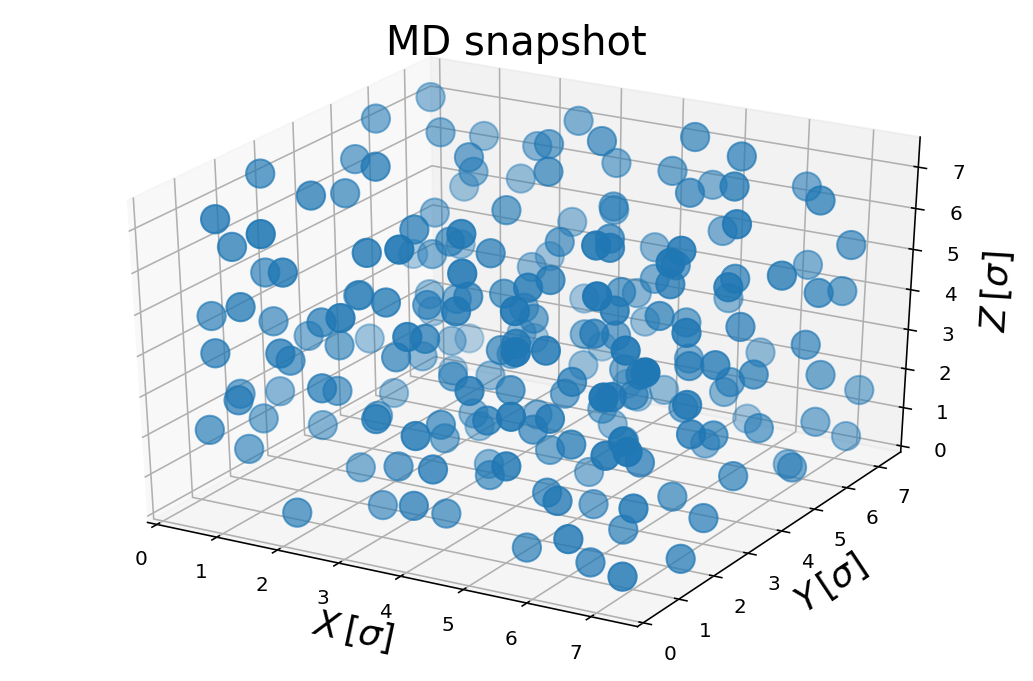

In [21]:
viz_p(pos,L)

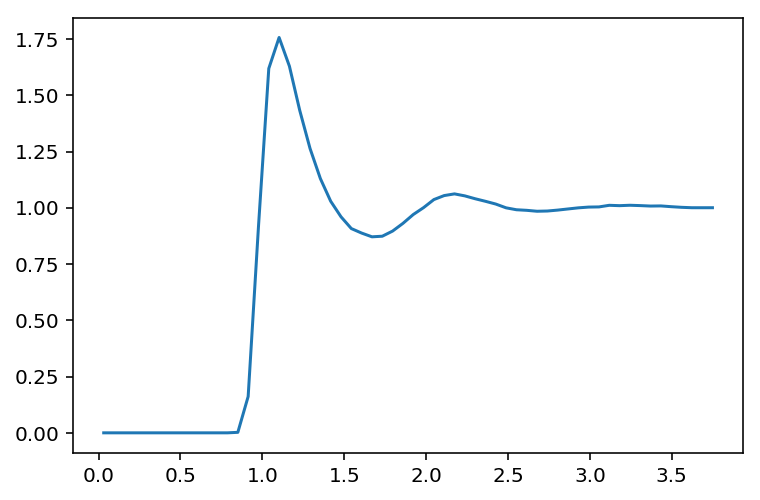

In [22]:
GR=0
freq=100

for i in range(freq):
    data=mdrun(N, L, rc2, dt, 100, T, pos, vel, force)
    x,y=comp_g_r(pos,N,L)
    GR+=y
    
plt.plot(x,GR/freq)
plt.xlabel('$r$',fontsize=20)
plt.ylabel('$g(r)$',fontsize=20)

In [79]:
'''Run this cell to render our markdown text with beautiful styles.'''
from IPython.core.display import HTML
def set_css_style(css_file_path):
    styles = open(css_file_path, "r").read()
    return HTML(styles)
set_css_style('./common/custom.css')